In [18]:
import random
import numpy as np
import copy
import matplotlib.pyplot as plt

INITIAL_STATE_ACTION_VALUES = {
    "A": {
        "left": 0,
        "right": 0
    },
    "B": {
        action: 0 for action in [f"action_{i}" for i in range(1, 15)]
    },
    "T_STATE": {
        
    }
}

B_ACTION_REWARDS = {
    action: random.normalvariate(-0.1, 1) for action in INITIAL_STATE_ACTION_VALUES["B"].keys()
}

T_STATE = "T_STATE"


def get_next_state_and_reward(state, action):
    if state == "A":
        if action == "left":
            return "B", 0
        else:
            return "T_STATE", 0
    else:
        return "T_STATE", random.normalvariate(-0.1, 1)

def random_argmax(actions, q):
    best_val = max(q[a] for a in actions)
    best = [a for a in actions if q[a] == best_val]
    return np.random.choice(best)

def get_available_actions(state):
    return INITIAL_STATE_ACTION_VALUES[state].keys()

def get_next_action(state, action_values, epsilon=0.1):
    available_actions = get_available_actions(state)
    
    # Convert dict_keys to a list for numpy.random.choice
    available_actions_list = list(available_actions)

    if np.random.random() < epsilon:
        return np.random.choice(available_actions_list)
    else:
        return random_argmax(available_actions_list, action_values[state])


def get_max_action_value(state, state_action_values):
    available_actions = get_available_actions(state)
    if state == T_STATE:
        return 0, None
    else:
        max_value = max(state_action_values[state][a] for a in available_actions)
        max_action = random_argmax(available_actions, state_action_values[state])
        return max_value, max_action

def get_epsilon(episode, initial_eps=.1, final_eps=0.001, decay_steps=150):
    if episode >= decay_steps:
        return final_eps
    return initial_eps - (initial_eps - final_eps) * (episode / decay_steps)


def generate_episode(state_action_values, epsilon=0.1):
    state = "A"
    episode = [state]
    while state != T_STATE:
        action = get_next_action(state, state_action_values, epsilon)
        state, reward = get_next_state_and_reward(state, action)
        episode.append(state)
    
    return episode

def train_q_learning(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=500,
    decay_steps=None,
    max_steps=float('inf')
):
    state_action_values = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    episode_rewards = []  # Track sum of rewards per episode
    episode_paths = []
    for i in range(episodes):
        state = "A"
        current_episode_reward = 0  # Sum of rewards for this episode
        step = 0
        current_episode_path = []
        while state != T_STATE and step < max_steps:
            step += 1
            
            action = get_next_action(state, state_action_values, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            next_state, r = get_next_state_and_reward(state, action)

            step_episodes.append(i)
            current_episode_reward += r  # Accumulate episode reward

            max_action_value, max_action = get_max_action_value(next_state, state_action_values)
            state_action_values[state][action] += alpha * (r + max_action_value - state_action_values[state][action])
            state = next_state
            current_episode_path.append(state)
        
        episode_rewards.append(current_episode_reward)  # Store episode total
        episode_paths.append(current_episode_path)
    return state_action_values, step_episodes, episode_rewards, episode_paths

def train_double_q_learning(
    initial_state_action_values,
    alpha=0.5,
    epsilon=0.1,
    episodes=500,
    decay_steps=None,
    max_steps=float('inf')
):
    state_action_values_1 = copy.deepcopy(initial_state_action_values)
    state_action_values_2 = copy.deepcopy(initial_state_action_values)
    step_episodes = []
    episode_rewards = []  # Track sum of rewards per episode
    episode_paths = []
    for i in range(episodes):
        state = "A"
        current_episode_reward = 0  # Sum of rewards for this episode
        step = 0
        current_episode_path = []
        while state != T_STATE and step < max_steps:
            step += 1
            
            action = get_next_action(state, state_action_values_1, get_epsilon(i, initial_eps=epsilon, final_eps=0.001, decay_steps=150) if decay_steps else epsilon)
            next_state, r = get_next_state_and_reward(state, action)

            step_episodes.append(i)
            current_episode_reward += r  # Accumulate episode reward

            if np.random.random() < 0.5:
                max_action_value, max_action = get_max_action_value(next_state, state_action_values_1)
                if next_state == T_STATE:
                    q2_sav = 0  # Terminal state has no future value
                else:
                    q2_sav = state_action_values_2[next_state][max_action]
                cur_sav = state_action_values_1[state][action]
                state_action_values_1[state][action] += alpha * (r + q2_sav - cur_sav)
            else:
                max_action_value, max_action = get_max_action_value(next_state, state_action_values_2)
                if next_state == T_STATE:
                    q1_sav = 0  # Terminal state has no future value
                else:
                    q1_sav = state_action_values_1[next_state][max_action]
                cur_sav = state_action_values_2[state][action]
                state_action_values_2[state][action] += alpha * (r + q1_sav - cur_sav)

            state = next_state
            current_episode_path.append(state)
        
        episode_rewards.append(current_episode_reward)  # Store episode total
        episode_paths.append(current_episode_path)
    return state_action_values_1, step_episodes, episode_rewards, episode_paths


def plot_episode(state_action_values, epsilon=0.1):
    episode_path = generate_episode(state_action_values, epsilon)
    print(f"Episode path: {' -> '.join(map(str, episode_path))}")

    fig, ax = plt.subplots(figsize=(len(episode_path) * 2.5, 3))

    # Lay out states horizontally
    for i, state in enumerate(episode_path):
        # Draw state node
        node_label = state if state != "T_STATE" else "Terminal"
        ax.text(i, 0, node_label, ha='center', va='center',
                bbox=dict(boxstyle="circle,pad=0.5", fc="skyblue", ec="b", lw=2),
                fontsize=12)

        # Draw arrow to the next state
        if i < len(episode_path) - 1:
            ax.arrow(i + 0.3, 0, 0.4, 0,
                     head_width=0.1, head_length=0.1, fc='k', ec='k', length_includes_head=True)

    ax.set_xlim(-0.5, len(episode_path) - 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axis('off')
    ax.set_title(f"Episode Path (epsilon={epsilon})", fontsize=14)
    plt.show()

def plot_percentage_of_left_actions(training_function):
    tenk_training_runs = [[] for _ in range(300)]
    for i in range(10000):
        q_state_action_values, q_step_episodes, q_episode_rewards, q_episode_paths = training_function(
            INITIAL_STATE_ACTION_VALUES,
            alpha=0.1,
            epsilon=0.1,
            episodes=300
        )
        for j in range(300):
            tenk_training_runs[j].append(q_episode_paths[j])


    number_of_left_actions = [0] * 300
    for j in range(300):
        for run in tenk_training_runs[j]:
            if run[0] == "B":
                number_of_left_actions[j] += 1

    percentage_of_left_actions = [n / 100 for n in number_of_left_actions]
    return percentage_of_left_actions

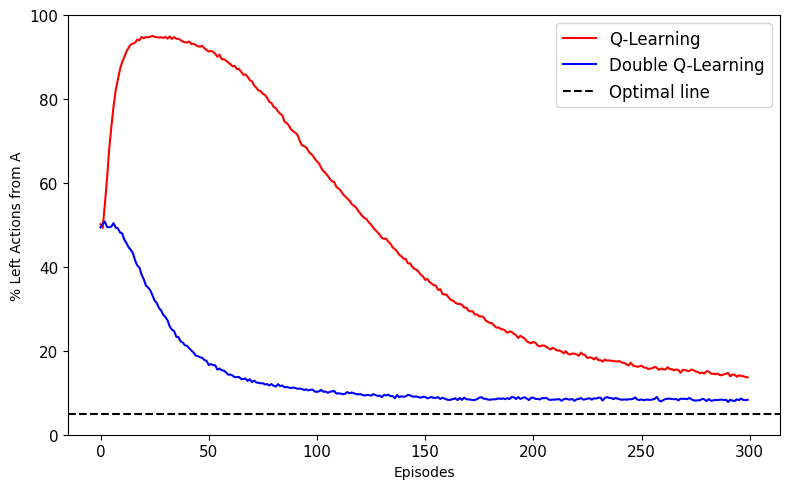

In [19]:
q_learning_percentage_of_left_actions = plot_percentage_of_left_actions(train_q_learning)
double_q_learning_percentage_of_left_actions = plot_percentage_of_left_actions(train_double_q_learning)

plt.figure(figsize=(8, 5))
plt.plot(q_learning_percentage_of_left_actions, label='Q-Learning', color='red')
plt.plot(double_q_learning_percentage_of_left_actions, label='Double Q-Learning', color='blue')

plt.axhline(y=5, 
            color='black', 
            linestyle='--', 
            label='Optimal line')

plt.xlabel("Episodes")
plt.ylabel("% Left Actions from A")

plt.ylim(0, 100)
plt.legend(loc='upper right', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()